## Setup: Importing and Defining the State

In [1]:
import numpy as np
import warnings
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from data_loader import MarketDataLoader
from quant_math_engine import bates_call_price, implied_volatility

BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"
loader = MarketDataLoader(BASE_DIR)

TARGET_DATE = '2024-01-10'
TARGET_EXDATE = '2024-02-16'
state = loader.get_market_state(TARGET_DATE, TARGET_EXDATE, strike_bound_pct=0.10)

S0, T, r, q = state['S0'], state['T'], state['r'], state['q']
market_strikes, market_prices = state['strikes'], state['prices']

target_ivs, valid_strikes = [], []
for i, K in enumerate(market_strikes):
    iv = implied_volatility(market_prices[i], S0, K, T, r, q)
    if not np.isnan(iv):
        target_ivs.append(iv)
        valid_strikes.append(K)

valid_strikes = np.array(valid_strikes)
target_ivs = np.array(target_ivs)
print(f"✅ Ready! Targeting {len(valid_strikes)} liquid strikes.")

Loading Options, Spot, Yield, and Dividend Data into memory...
✅ Data Loaded Successfully.
✅ Ready! Targeting 352 liquid strikes.


## Calibration of the Bates Model

In [2]:
def bates_objective(params):
    v0, kappa, theta, xi, rho, lam, mu_j, delta = params
    error = 0.0
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, K in enumerate(valid_strikes):
            m_price = bates_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho, lam, mu_j, delta)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv): error += 5.0
            else: error += (m_iv - target_ivs[i])**2
                
    return error / len(valid_strikes)

# Parameter Seeding: [v0, kappa, theta, xi, rho, lam, mu_j, delta]
# We start exactly where Heston and Merton left off!
bates_guess = [0.0115, 3.0293, 0.0684, 1.1963, -0.6572, 0.9923, -0.0825, 0.0779]

bates_bounds = [
    (0.005, 0.15), (0.5, 5.0), (0.005, 0.15), (0.05, 1.5), (-0.95, -0.2), # Heston bounds
    (0.0, 3.0), (-0.5, 0.0), (0.01, 0.3)                                  # Merton bounds
]

print("Optimizing Bates Parameters (Seeded Fast Search)...")
start_time = time.time()
res_bates = minimize(bates_objective, bates_guess, method='L-BFGS-B', bounds=bates_bounds)

print(f"✅ Finished in {round(time.time() - start_time, 2)}s")
print(f"Optimal Parameters: {res_bates.x}")
print(f"Mean Squared Error: {res_bates.fun:.6f}")

Optimizing Bates Parameters (Seeded Fast Search)...
✅ Finished in 739.89s
Optimal Parameters: [ 0.01351544  3.02896821  0.05295653  1.19200183 -0.64808761  0.98712586
  0.          0.01872268]
Mean Squared Error: 0.000031


## Visualising the Model against Live Data

Generating Bates Volatility Smile...


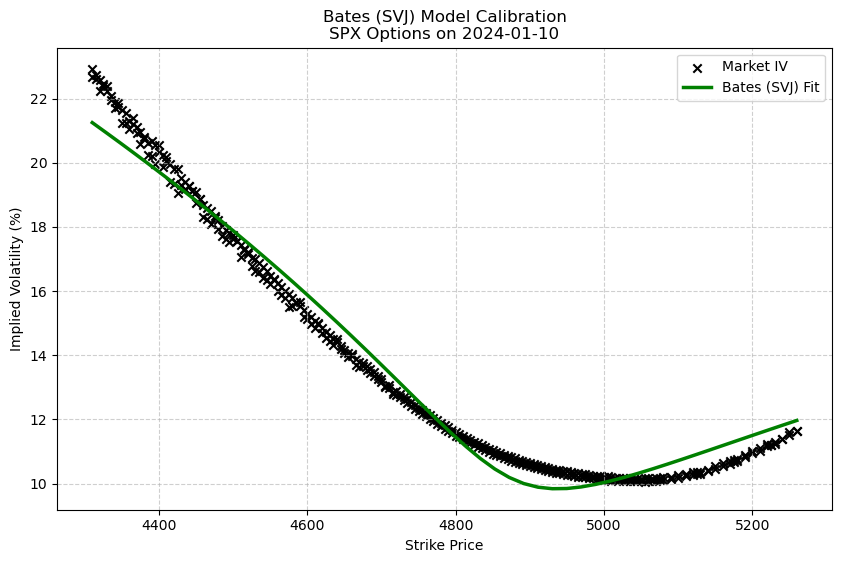

In [3]:
print("Generating Bates Volatility Smile...")

smooth_strikes = np.linspace(min(valid_strikes), max(valid_strikes), 50)
bates_prices = [bates_call_price(S0, k, T, r, q, *res_bates.x) for k in smooth_strikes]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bates_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(bates_prices, smooth_strikes)]

valid_idx = ~np.isnan(bates_iv)
clean_strikes = np.array(smooth_strikes)[valid_idx]
clean_iv = np.array(bates_iv)[valid_idx] * 100

plt.figure(figsize=(10, 6))
plt.scatter(valid_strikes, target_ivs * 100, color='black', label='Market IV', marker='x')
plt.plot(clean_strikes, clean_iv, color='green', label='Bates (SVJ) Fit', linewidth=2.5)

plt.title(f"Bates (SVJ) Model Calibration\nSPX Options on {TARGET_DATE}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()